##German Credit - Import

#Setup


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml

pd.set_option('display.max_columns', None)
pd.set_option('display.width',1000)
pd.set_option('display.max_rows', None)

sns.set_style("darkgrid")

from IPython.display import display, Markdown
from pprint import pprint 

DEBUG = True

#Dataset

In [ ]:
DATASET = "German Credit"

import os, sys
COLAB = 'google.colab' in sys.modules

if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
  ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
  if not os.path.isdir(ROOT): os.makedirs(ROOT)
else:
  ROOT = "./"

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

Mounted at /content/gdrive


In [ ]:
for filename in ["german.data", "german.data", "german.doc", "german.data-numeric"]:
    source = f"https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/{filename}"
    target = f"{ROOT}/orig/{filename}"
    if not os.path.isfile(target):
        print (f"Downloading remote file {filename}", sep="")
        import urllib.request
        urllib.request.urlretrieve(source, target)
    else:
        print(f"Using local copy of {filename}")

Using local copy of german.data


In [ ]:
df = pd.read_csv(f"{ROOT}/orig/german.data", sep =" ", header=None)
print(df.shape)
df.head(5)

(1000, 21)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [ ]:
df.columns = ["Account_Balance", "Loan_Duration", "Credit_History", 
    "Loan_Purpose", "Loan_Amount", "Savings", "Years_Employed", 
    "Installment_Rate", "Gender_and_Status", "Other_Debtors_Guarantors",
    "Year_of_Residence", "Property", "Age", "Installment_Plans", "Housing", "Existing_Credits", "Job", "Dependents", 
    "Telephone", "Foreign", 
    "Credit_Rating"]

In [ ]:
df_labeled = df.copy()
df_labeled.head(5)

,Account_Balance,Loan_Duration,Credit_History,Loan_Purpose,Loan_Amount,Savings,Years_Employed,Installment_Rate,Gender_and_Status,Other_Debtors_Guarantors,Year_of_Residence,Property,Age,Installment_Plans,Housing,Existing_Credits,Job,Dependents,Telephone,Foreign,Credit_Rating
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [ ]:
#Read document file in and strip each line
lines = [line.strip() for line in open("orig/german.doc").readlines()]
lines[:4]

['Description of the German credit dataset.',
 '',
 '1. Title: German Credit data',
 '']

In [ ]:
#Define function to test for code line
is_code_line = lambda line: len(line)>2 and line[0]=="A" and line[1].isdigit()
is_code_line("AB112")

False

In [ ]:
#Filter out non-code lines
code_lines = [line for line in lines if is_code_line(line)]
code_lines[:5]

['A11 :      ... <    0 DM',
 'A12 : 0 <= ... <  200 DM',
 'A13 :      ... >= 200 DM /',
 'A14 : no checking account',
 'A30 : no credits taken/']

In [ ]:
#Define function to clean a code line
import re

total_strip = lambda s: re.sub('[ ]+', ' ', s.strip())
total_strip('   A14    :     no checking account   ')

'A14 : no checking account'

In [ ]:
#Build mapping to convert code to description
mapping = { 
    total_strip(code): total_strip(text)
  for code, text in [line.split(":",1) for line in code_lines]
} 
mapping['A11']

'... < 0 DM'

In [ ]:
#Want to insert code into description
mapping = {k:f"({k}) {v}" for k,v in mapping.items()}

In [ ]:
#Get all columns that contain codes
code_columns = df.select_dtypes('object').columns
code_columns

Index(['Account_Balance', 'Credit_History', 'Loan_Purpose', 'Savings', 'Years_Employed', 'Gender_and_Status', 'Other_Debtors_Guarantors', 'Property', 'Installment_Plans', 'Housing', 'Job', 'Telephone', 'Foreign'], dtype='object')

In [ ]:
#Apply mapping
df_labeled = df.copy()
for c in code_columns:
  df_labeled[c] = df_labeled[c].map(mapping)

df_labeled.head()

,Account_Balance,Loan_Duration,Credit_History,Loan_Purpose,Loan_Amount,Savings,Years_Employed,Installment_Rate,Gender_and_Status,Other_Debtors_Guarantors,Year_of_Residence,Property,Age,Installment_Plans,Housing,Existing_Credits,Job,Dependents,Telephone,Foreign,Credit_Rating
0,(A11) ... < 0 DM,6,(A34) critical account/,(A43) radio/television,1169,(A65) unknown/ no savings account,(A75) .. >= 7 years,4,(A93) male : single,(A101) none,4,(A121) real estate,67,(A143) none,(A152) own,2,(A173) skilled employee / official,1,"(A192) yes, registered under the customers name",(A201) yes,1
1,(A12) 0 <= ... < 200 DM,48,(A32) existing credits paid back duly till now,(A43) radio/television,5951,(A61) ... < 100 DM,(A73) 1 <= ... < 4 years,2,(A92) female : divorced/separated/married,(A101) none,2,(A121) real estate,22,(A143) none,(A152) own,1,(A173) skilled employee / official,1,(A191) none,(A201) yes,2
2,(A14) no checking account,12,(A34) critical account/,(A46) education,2096,(A61) ... < 100 DM,(A74) 4 <= ... < 7 years,2,(A93) male : single,(A101) none,3,(A121) real estate,49,(A143) none,(A152) own,1,(A172) unskilled - resident,2,(A191) none,(A201) yes,1
3,(A11) ... < 0 DM,42,(A32) existing credits paid back duly till now,(A42) furniture/equipment,7882,(A61) ... < 100 DM,(A74) 4 <= ... < 7 years,2,(A93) male : single,(A103) guarantor,4,(A122) if not A121 : building society savings ...,45,(A143) none,(A153) for free,1,(A173) skilled employee / official,2,(A191) none,(A201) yes,1
4,(A11) ... < 0 DM,24,(A33) delay in paying off in the past,(A40) car (new),4870,(A61) ... < 100 DM,(A73) 1 <= ... < 4 years,3,(A93) male : single,(A101) none,4,(A124) unknown / no property,53,(A143) none,(A153) for free,2,(A173) skilled employee / official,2,(A191) none,(A201) yes,2


In [ ]:
#Check if mapping failed - should have no missing values
df_labeled.isna().sum().sum()

0

##Q1 - What is the total of Loan_Amount?

In [ ]:
df_labeled.Loan_Amount.sum()

3271258

##Q2 - What is the mean Loan_Duration to 2DP?

In [ ]:
df_labeled.Loan_Duration.mean()

20.903

##Q3 - What is the standard deviation of Loan_Amount (to 2DP)?

In [ ]:
df_labeled.Loan_Amount.std()

2822.7368759604406

##Q4 - What is the mean Loan_Amount for applications that have Year_of_Residence equal to 1 (answer to 2DP)?

In [ ]:
df_labeled.groupby(df_labeled.Year_of_Residence == 1)['Loan_Amount'].mean()

Year_of_Residence
False    3322.732184
True     2926.776923
Name: Loan_Amount, dtype: float64

##Q5 - What is the range of Loan_Amount?

In [ ]:
df_labeled.Loan_Amount.max()-df_labeled.Loan_Amount.min()

18174

##Q6 - Classify the Age distribution as:

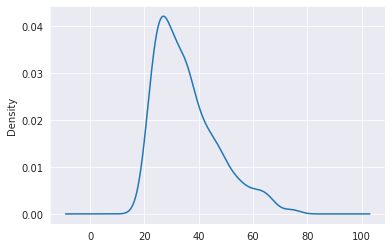

In [ ]:
df_labeled.Age.plot(kind = 'kde')

##Q7 - What is the interquartile range (IQR) of Loan_Amount (to 2DP)?

In [ ]:
q75, q25 = np.percentile(df_labeled.Loan_Amount, [75 ,25])
iqr = q75 - q25
 
iqr

2606.75

##Q8 - Using the 1.5*IQR from the quartiles rule, how many outlier observations are in Loan_Amount?

In [ ]:
l_range = q25 - 1.5 * iqr
u_range = q75 + 1.5 * iqr
outlier = [loan for loan in df_labeled.Loan_Amount  if ((loan > l_range) & (loan < u_range))]
df_labeled.Loan_Amount.size - len(outlier)

72

##Q9 - What is the third most popular reason cited for loan?

In [ ]:
df_labeled.Loan_Purpose.value_counts()

(A43) radio/television       280
(A40) car (new)              234
(A42) furniture/equipment    181
(A41) car (used)             103
(A49) business                97
(A46) education               50
(A45) repairs                 22
(A44) domestic appliances     12
(A410) others                 12
(A48) retraining               9
Name: Loan_Purpose, dtype: int64

##Q10 - How many distinct reasons are cited for asking for a loan?

In [ ]:
reasons = df_labeled.Loan_Purpose.unique()
len(reasons)

10

##Q11 - Which reason cited for loan has the highest rate of bad claims?

In [ ]:
df_labeled.groupby(df_labeled.Credit_Rating == 1)['Loan_Purpose'].value_counts().rank()

Credit_Rating  Loan_Purpose             
False          (A40) car (new)              17.0
               (A43) radio/television       14.0
               (A42) furniture/equipment    13.0
               (A49) business               12.0
               (A46) education              10.0
               (A41) car (used)              9.0
               (A45) repairs                 6.0
               (A410) others                 3.0
               (A44) domestic appliances     2.0
               (A48) retraining              1.0
True           (A43) radio/television       20.0
               (A40) car (new)              19.0
               (A42) furniture/equipment    18.0
               (A41) car (used)             16.0
               (A49) business               15.0
               (A46) education              11.0
               (A45) repairs                 8.0
               (A44) domestic appliances     6.0
               (A48) retraining              6.0
               (A410) others

##Q12 - Which Credit_History has the lowest rate of bad claims?

In [ ]:
df_labeled.groupby(df_labeled.Credit_Rating == 1)['Credit_History'].value_counts().rank()

Credit_Rating  Credit_History                                
False          (A32) existing credits paid back duly till now     8.0
               (A34) critical account/                            6.0
               (A31) all credits at this bank paid back duly      4.5
               (A33) delay in paying off in the past              4.5
               (A30) no credits taken/                            3.0
True           (A32) existing credits paid back duly till now    10.0
               (A34) critical account/                            9.0
               (A33) delay in paying off in the past              7.0
               (A31) all credits at this bank paid back duly      2.0
               (A30) no credits taken/                            1.0
Name: Credit_History, dtype: float64

##Q13 - What is the average age of applicants that have Credit_Rating of Bad?

In [ ]:
df_labeled.groupby(df_labeled.Credit_Rating == 1)['Age'].mean()

Credit_Rating
False    33.963333
True     36.224286
Name: Age, dtype: float64

##Q14 - How many reasons cited for loans have a mean Loan_Duration greater than the mean of Loan_Duration overall?

In [ ]:
df_labeled.groupby(df_labeled.Loan_Duration > df_labeled.Loan_Duration.mean())

##Q15 - What is the correlation between Loan_Duration and Loan_Amount (to 2DP)?

In [ ]:
df_labeled.Loan_Duration.corr(df_labeled.Loan_Amount)

0.6249841983009836

##Q16 - What is the probability of an applicant is female? (enter answer as a decimal to 2DP)?

In [ ]:
total = 1000
females = df_labeled.Gender_and_Status.str.contains('female').value_counts()
probability = females/total
probability

False    0.69
True     0.31
Name: Gender_and_Status, dtype: float64

##Q17 - What is the probability of an applicant that owns their own property, does not have a telephone? (enter answer as a decimal to 2DP)?

In [ ]:
telephone = df_labeled.Telephone.str.contains('none').value_counts()
prob = telephone/total
prob

True     0.596
False    0.404
Name: Telephone, dtype: float64

##Q18 - Which categorical feature has the most impact on the target (using chi2 as the metric)?